# WBIC

This notebook gives a tutorial on how to use Watanabe-Bayesian information criterion (WBIC) for feature selection. The WBIC is an information criterion. Similarly to other criteria (AIC, BIC, DIC) the WBIC endeavors to find the most parsimonious model, i.e., the model that balances fit with complexity. In other words a model (or set of features) that optimizes WBIC should neither over nor under fit the available data. 

In this tutorial a data set is simulated using the damped linear trend (DLT) model. This data set is then used to fit DLT models with varying number of features as well as a global local trent model (GLT), and a Error-Trend-Seasonal (ETS) model. The WBIC criteria is then show to find the true model. 


In [1]:
from datetime import timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import orbit
from orbit.models import DLT,ETS, KTRLite, LGT
from orbit.utils.simulation import make_trend, make_regression

In [2]:
print(orbit.__version__)

1.1.0dev


## Data Simulation

This block of code creats random data set (365 observations with 10 features) assuming a DLT model. Of the 10 features 5 are effective regressors; i.e., they are used in the true model to create the data.

As an exerise left to the user once you have run the code once try changing the NUM_OF_EFFECTIVE_REGRESSORS (line 2), the SERIES_LEN (line 3), and the SEED (line 4) to see how it effects the results. 

In [3]:
NUM_OF_REGRESSORS = 10
NUM_OF_EFFECTIVE_REGRESSORS = 5
SERIES_LEN = 365
SEED = 1
# sample some coefficients
COEFS = np.random.default_rng(SEED).uniform(-1, 1, NUM_OF_EFFECTIVE_REGRESSORS)
trend = make_trend(SERIES_LEN, rw_loc=0.01, rw_scale=0.1)
x, regression, coefs = make_regression(series_len=SERIES_LEN, coefs=COEFS)

# combine trend and the regression
y = trend + regression
y = y - y.min()


x_extra = np.random.normal(0, 1, (SERIES_LEN, NUM_OF_REGRESSORS - NUM_OF_EFFECTIVE_REGRESSORS))
x = np.concatenate([x, x_extra], axis=-1)

x_cols = [f"x{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "y"
dt_col = "date"
obs_matrix = np.concatenate([y.reshape(-1, 1), x], axis=1)
# make a data frame for orbit inputs
df = pd.DataFrame(obs_matrix, columns=[response_col] + x_cols)
# make some dummy date stamp
dt = pd.date_range(start='2016-01-04', periods=SERIES_LEN, freq="1W")
df['date'] = dt

In [4]:
print(df.shape)
print(df.head())

(365, 12)
          y        x1        x2        x3        x4        x5        x6  \
0  3.192673  0.172792  0.000000  0.165219 -0.000000  0.452678 -0.185234   
1  3.951436  0.223187 -0.000000  0.290559  0.182286  0.147066 -0.417827   
2  4.122889  0.014211  0.273356 -0.368227 -0.081455 -0.241060  0.576455   
3  1.669311  0.299423  0.019861 -0.146228 -0.390954 -0.128596 -0.638395   
4  3.567194  0.004071 -0.137801  0.647032  0.000000 -0.000000 -0.972022   

         x7        x8        x9       x10       date  
0  0.341803  0.428195 -1.703204  1.564714 2016-01-10  
1 -0.086061  0.688094  0.972574  0.418016 2016-01-17  
2  0.242074 -0.783067  1.186814 -0.096372 2016-01-24  
3  1.507464  0.085937 -0.176181  0.465819 2016-01-31  
4  0.524237  0.447896 -0.393606 -0.341384 2016-02-07  


## WBIC

In this section, we use DLT model as an example. Different DLT models are fitted and their WBIC values are calculated respectively.

In [5]:
WBIC_ls = []
for k in range(0, NUM_OF_REGRESSORS):
    regressor_col = x_cols[:k + 1]
    dlt_mod = DLT(
        response_col=response_col,
        date_col=dt_col,
        regressor_col=regressor_col,
        seed=2022,
        # fixing the smoothing parameters to learn regression coefficients more effectively
        level_sm_input=0.01,
        slope_sm_input=0.01,
        num_warmup=4000,
        num_sample=4000,
        )
    WBIC_temp = dlt_mod.fit_wbic(df=df) 
    print(f"WBIC value with {k} regressors: {WBIC_temp}")
    print('------------------------------------------------------------------')
    WBIC_ls.append(WBIC_temp)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


WBIC value with 0 regressors: 1198.1808527417447
------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


WBIC value with 1 regressors: 1125.9597910329205
------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


WBIC value with 2 regressors: 1117.046308310887
------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


WBIC value with 3 regressors: 1052.5908845621518
------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


WBIC value with 4 regressors: 1051.6486730037443
------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


WBIC value with 5 regressors: 1056.0510692425216
------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


WBIC value with 6 regressors: 1062.2622936292132
------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


WBIC value with 7 regressors: 1066.5409042769363
------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


WBIC value with 8 regressors: 1067.1040215574926
------------------------------------------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


WBIC value with 9 regressors: 1071.5625755506535
------------------------------------------------------------------


The plot below shows the WBIC vs the number of features (blue line). The true model is indicated by the vertical red line. The horizontal gray line shows the minimum (optimal) value.

Text(0.5, 0, '# number of Features')

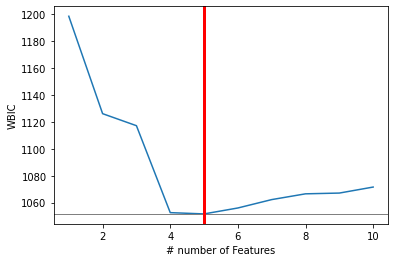

In [6]:
num_reg_ls = list(range(1, NUM_OF_REGRESSORS+1))
plt.plot(num_reg_ls, WBIC_ls, )
plt.axhline(y=min(WBIC_ls), color='grey', linewidth = 1)
plt.axvline(x=NUM_OF_EFFECTIVE_REGRESSORS, color='red', linewidth = 3)
plt.ylabel("WBIC")
plt.xlabel("# number of Features")